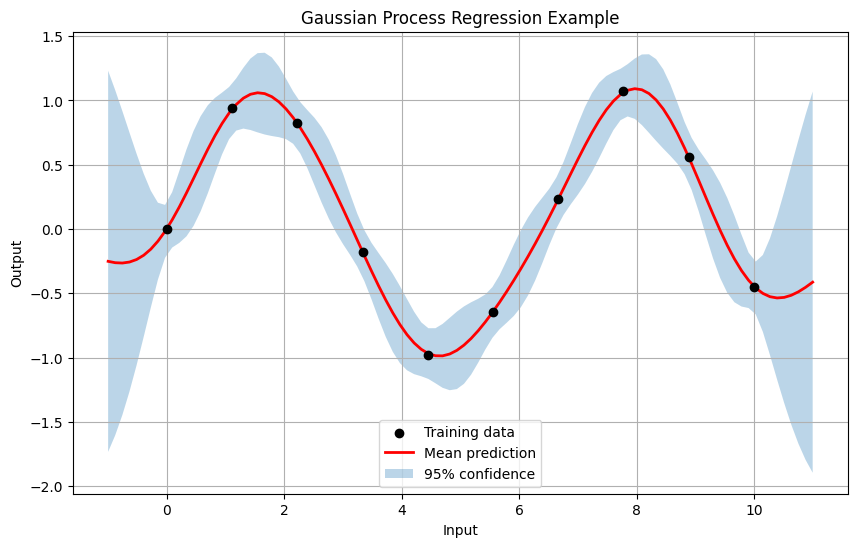

In [10]:
# Gaussian Process Regression - Comprehensive Implementation

import jax.numpy as jnp
import jax.random as random
from scipy.stats import norm
import matplotlib.pyplot as plt

class KernelFunction:
    """Base class for kernel functions"""
    
    @staticmethod
    def squared_exponential(tau, kappa, lengthscale):
        """
        Squared exponential (RBF) kernel
        k(x, x') = κ² exp(-||x-x'||²/(2ℓ²))
        
        Args:
            tau: distance ||x - x'||
            kappa: magnitude parameter
            lengthscale: lengthscale parameter
        """
        return kappa**2 * jnp.exp(-0.5 * tau**2 / lengthscale**2)
    
    @staticmethod
    def matern12(tau, kappa, lengthscale):
        """
        Matérn 1/2 kernel (Ornstein-Uhlenbeck process)
        k(x, x') = κ² exp(-||x-x'||/ℓ)
        """
        return kappa**2 * jnp.exp(-tau / lengthscale)
    
    @staticmethod
    def matern32(tau, kappa, lengthscale):
        """
        Matérn 3/2 kernel
        k(x, x') = κ² (1 + √3||x-x'||/ℓ) exp(-√3||x-x'||/ℓ)
        """
        scaled_dist = jnp.sqrt(3) * tau / lengthscale
        return kappa**2 * (1 + scaled_dist) * jnp.exp(-scaled_dist)

class StationaryIsotropicKernel:
    """Stationary isotropic kernel class"""
    
    def __init__(self, kernel_func):
        self.kernel_func = kernel_func
    
    def compute_distances(self, X1, X2):
        """Compute pairwise Euclidean distances between X1 and X2"""
        # Using broadcasting to compute all pairwise distances
        # X1: (N1, D), X2: (N2, D)
        # Result: (N1, N2) matrix of distances
        diff = X1[:, None, :] - X2[None, :, :]  # (N1, N2, D)
        distances = jnp.sqrt(jnp.sum(diff**2, axis=2))  # (N1, N2)
        return distances
    
    def construct_kernel(self, X1, X2, kappa, lengthscale, jitter=0.0):
        """
        Construct kernel matrix K(X1, X2)
        
        Args:
            X1: (N1, D) array of input points
            X2: (N2, D) array of input points
            kappa: magnitude parameter
            lengthscale: lengthscale parameter
            jitter: small value for numerical stability
            
        Returns:
            K: (N1, N2) kernel matrix
        """
        distances = self.compute_distances(X1, X2)
        K = self.kernel_func(distances, kappa, lengthscale)
        
        # Add jitter to diagonal for numerical stability
        if jitter > 0 and X1.shape[0] == X2.shape[0]:
            K = K + jitter * jnp.eye(X1.shape[0])
        
        return K

class GaussianProcessRegression:
    """Complete Gaussian Process Regression implementation"""
    
    def __init__(self, X, y, kernel, kappa=1., lengthscale=1., sigma=0.5, jitter=1e-8):
        """
        Initialize GP regression model
        
        Args:
            X: (N, D) training inputs
            y: (N, 1) training outputs
            kernel: kernel object
            kappa: kernel magnitude
            lengthscale: kernel lengthscale
            sigma: noise standard deviation
            jitter: numerical stability parameter
        """
        self.X = X
        self.y = y
        self.N = len(X)
        self.kernel = kernel
        self.jitter = jitter
        self.set_hyperparameters(kappa, lengthscale, sigma)
        self.check_dimensions()
    
    def set_hyperparameters(self, kappa, lengthscale, sigma):
        """Set model hyperparameters"""
        self.kappa = kappa
        self.lengthscale = lengthscale
        self.sigma = sigma
    
    def check_dimensions(self):
        """Verify input dimensions are correct"""
        assert self.X.ndim == 2, f"X must be 2D, got shape {self.X.shape}"
        assert self.y.ndim == 2, f"y must be 2D, got shape {self.y.shape}"
        assert self.y.shape == (self.N, 1), f"y shape mismatch: {self.y.shape}"
    
    def predict_f(self, Xstar):
        """
        Compute posterior distribution of f* at test points
        
        Implements:
        μ*|X = K*X (KXX + σ²I)^(-1) y
        Σ*|X = K** - K*X (KXX + σ²I)^(-1) KX*
        
        Args:
            Xstar: (P, D) test points
            
        Returns:
            mu: (P, 1) posterior mean
            Sigma: (P, P) posterior covariance
        """
        # Compute kernel matrices
        K_XX = self.kernel.construct_kernel(self.X, self.X, self.kappa, 
                                          self.lengthscale, self.jitter)
        K_star_star = self.kernel.construct_kernel(Xstar, Xstar, self.kappa, 
                                                 self.lengthscale, self.jitter)
        K_X_star = self.kernel.construct_kernel(self.X, Xstar, self.kappa, 
                                              self.lengthscale)
        
        # Add noise to training covariance
        K_sigma = K_XX + self.sigma**2 * jnp.eye(self.N)
        
        # Compute posterior mean: μ*|X = K*X (KXX + σ²I)^(-1) y
        alpha = jnp.linalg.solve(K_sigma, self.y)
        mu = K_X_star.T @ alpha
        
        # Compute posterior covariance: Σ*|X = K** - K*X (KXX + σ²I)^(-1) KX*
        v = jnp.linalg.solve(K_sigma, K_X_star)
        Sigma = K_star_star - K_X_star.T @ v
        
        return mu, Sigma
    
    def predict_y(self, Xstar):
        """
        Compute posterior predictive distribution of y* at test points
        
        This adds observation noise to the function predictions:
        p(y*|X,y) = N(y*|μ*|X, Σ*|X + σ²I)
        
        Args:
            Xstar: (P, D) test points
            
        Returns:
            mu: (P, 1) predictive mean
            Sigma_y: (P, P) predictive covariance
        """
        mu, Sigma_f = self.predict_f(Xstar)
        Sigma_y = Sigma_f + self.sigma**2 * jnp.eye(len(Xstar))
        return mu, Sigma_y
    
    def posterior_samples(self, key, Xstar, num_samples):
        """
        Generate samples from posterior distribution
        
        Args:
            key: JAX random key
            Xstar: (P, D) test points
            num_samples: number of samples to generate
            
        Returns:
            samples: (P, num_samples) array of samples
        """
        mu, Sigma = self.predict_f(Xstar)
        
        # Cholesky decomposition for sampling
        L = jnp.linalg.cholesky(Sigma + 1e-6 * jnp.eye(len(Xstar)))
        
        # Generate standard normal samples
        z = random.normal(key, shape=(len(Xstar), num_samples))
        
        # Transform to posterior samples: f = μ + L @ z
        samples = mu + L @ z
        
        return samples
    
    def log_marginal_likelihood(self, kappa, lengthscale, sigma):
        """
        Compute log marginal likelihood log p(y|X,θ)
        
        Implements:
        log p(y|X,θ) = -½[y^T (K+σ²I)^(-1) y + log|K+σ²I| + n log(2π)]
        
        Args:
            kappa: kernel magnitude
            lengthscale: kernel lengthscale
            sigma: noise standard deviation
            
        Returns:
            log_ml: scalar log marginal likelihood
        """
        # Compute kernel matrix
        K = self.kernel.construct_kernel(self.X, self.X, kappa, lengthscale)
        
        # Add noise: C = K + σ²I
        C = K + sigma**2 * jnp.eye(self.N)
        
        # Cholesky decomposition for stable computation
        L = jnp.linalg.cholesky(C)
        
        # Solve L @ v = y
        v = jnp.linalg.solve(L, self.y)
        
        # Compute terms:
        # 1. Data fit term: -½ y^T C^(-1) y = -½ ||v||²
        quad_term = -0.5 * jnp.sum(v**2)
        
        # 2. Complexity penalty: -½ log|C| = -Σ log(diag(L))
        logdet_term = -jnp.sum(jnp.log(jnp.diag(L)))
        
        # 3. Constant term: -½ n log(2π)
        const_term = -0.5 * self.N * jnp.log(2 * jnp.pi)
        
        return quad_term + logdet_term + const_term
import numpy as np
# Visualization function
def plot_gp_predictions(X_train, y_train, X_test, gp_model, title="GP Predictions"):
    """
    Plot GP predictions with uncertainty bands
    
    Args:
        X_train: (N,1) training inputs
        y_train: (N,1) training outputs
        X_test:  (P,1) test inputs
        gp_model: trained GP model
        title: plot title
    """
    # Get predictions
    mu_j, Sigma_j = gp_model.predict_f(X_test)
    
    # Convert to numpy and flatten to 1-D
    mu  = np.array(mu_j).ravel()                    # shape (P,)
    std = np.sqrt(np.diag(np.array(Sigma_j)))     # shape (P,)
    X   = np.array(X_test).ravel()                  # shape (P,)
    
    # Create plot
    plt.figure(figsize=(10, 6))
    
    # Plot training data
    plt.scatter(np.array(X_train).ravel(), np.array(y_train).ravel(),
                color='black', label='Training data', zorder=3)
    
    # Plot mean prediction
    plt.plot(X, mu, 'r-', label='Mean prediction', linewidth=2)
    
    # Plot confidence intervals
    plt.fill_between(X,
                     mu - 2*std,
                     mu + 2*std,
                     alpha=0.3, label='95% confidence')
    
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()
# Example usage
if __name__ == "__main__":
    # Generate synthetic data
    N = 10
    X_train = jnp.linspace(0, 10, N).reshape(-1, 1)
    y_train = jnp.sin(X_train) + 0.1 * random.normal(random.PRNGKey(42), shape=(N, 1))
    
    
    
    # Create GP model
    kernel = StationaryIsotropicKernel(KernelFunction.squared_exponential)
    gp = GaussianProcessRegression(X_train, y_train, kernel, 
                                 kappa=1.0, lengthscale=1.0, sigma=0.1)
    
    # Make predictions
    X_test = jnp.linspace(-1, 11, 100).reshape(-1, 1)
    
    # Plot results
    plot_gp_predictions(X_train, y_train, X_test, gp, 
                       "Gaussian Process Regression Example")

In [11]:
# Bicycle Count Prediction - Complete Code Walkthrough

import jax.numpy as jnp
import jax.random as random
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Step 1: Data Loading and Preprocessing
# ====================================

# Load bicycle count data
data = jnp.load('../data_exercise5b.npz')
day = data['day']           # Days since 1/1/2011
bike_count = data['bike_count']  # Daily bike counts

# Data preprocessing (critical for GP performance)
# 1. Log transform to handle skewed count data
y_raw = jnp.log(bike_count)

# 2. Standardize for numerical stability
bmean, bstd = jnp.mean(y_raw), jnp.std(y_raw)
standardize = lambda t: (t - bmean) / bstd
y = standardize(y_raw).reshape(-1, 1)  # Shape: (N, 1)

# 3. Prepare input features
X = day.reshape(-1, 1)  # Shape: (N, 1)

print(f"Data shape: X={X.shape}, y={y.shape}")
print(f"Standardization: mean={bmean:.3f}, std={bstd:.3f}")


# Step 2: Gaussian Process Model Setup
# ===================================

# Initialize kernel (squared exponential)
kernel = StationaryIsotropicKernel(squared_exponential)

# Create GP regression model
gp = GaussianProcessRegression(X, y, kernel)

# Initial hyperparameters
theta_init = jnp.array([1.0, 1.0, 50.0])  # [kappa, lengthscale, sigma]


# Step 3: Hyperparameter Optimization
# ==================================

def optimize_hyperparameters(gp_model, theta_init):
    """
    Find optimal hyperparameters by maximizing log marginal likelihood
    
    Maximizes: log p(y|X,θ) w.r.t. θ = [κ, ℓ, σ]
    """
    def neg_log_ml(theta):
        kappa, lengthscale, sigma = theta
        # Return negative log ML for minimization
        return -gp_model.log_marginal_likelihood(kappa, lengthscale, sigma)
    
    # Optimize using scipy
    result = minimize(
        neg_log_ml,
        theta_init,
        method='L-BFGS-B',
        bounds=[(1e-2, 10), (1e-2, 100), (1e-2, 10)]  # Bounds for stability
    )
    
    if not result.success:
        print(f"Optimization warning: {result.message}")
    
    return result.x

# Find optimal hyperparameters
theta_hat = optimize_hyperparameters(gp, theta_init)
kappa_hat, scale_hat, sigma_hat = theta_hat

# Set optimized hyperparameters
gp.set_hyperparameters(kappa_hat, scale_hat, sigma_hat)

print(f"\nOptimized hyperparameters:")
print(f"  κ (magnitude): {kappa_hat:.3f}")
print(f"  ℓ (lengthscale): {scale_hat:.3f}")
print(f"  σ (noise std): {sigma_hat:.3f}")
print(f"  Log ML: {gp.log_marginal_likelihood(kappa_hat, scale_hat, sigma_hat):.3f}")


# Step 4: Making Predictions
# =========================

# Create prediction grid
days_pred = jnp.arange(0, 500, 1).reshape(-1, 1)  # Extended time range

# Get posterior predictions
mu_post, Sigma_post = gp.predict_f(days_pred)

# For comparison, create prior GP (no data)
gp_prior = GaussianProcessRegression(
    jnp.zeros((0, 1)), jnp.zeros((0, 1)), kernel
)
gp_prior.set_hyperparameters(kappa_hat, scale_hat, sigma_hat)


# Step 5: Visualization
# ====================

def plot_with_uncertainty(ax, Xp, gp, color='r', num_samples=0, title=""):
    """Enhanced visualization with uncertainty bands and samples"""
    
    # Get predictions
    mu, Sigma = gp.predict_f(Xp)
    std = jnp.sqrt(jnp.diag(Sigma))
    
    # Plot mean and confidence bands
    ax.plot(Xp, mu, color=color, linewidth=2, label='Mean')
    ax.fill_between(
        Xp.ravel(),
        (mu - 2*std).ravel(),
        (mu + 2*std).ravel(),
        alpha=0.3, color=color, label='95% confidence'
    )
    
    # Draw samples if requested
    if num_samples > 0:
        key = random.PRNGKey(0)
        samples = gp.posterior_samples(key, Xp, num_samples)
        ax.plot(Xp, samples[:, :10], color='blue', alpha=0.3, linewidth=0.5)
    
    ax.set_title(title)
    ax.legend()

# Create comparison plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Prior predictive
ax1.plot(X, y, 'k.', label='Training data', markersize=4)
plot_with_uncertainty(ax1, days_pred, gp_prior, 
                     title='Prior Predictive', num_samples=10)
ax1.set_xlim(0, 370)
ax1.set_xlabel('Days since 1/1/2011')
ax1.set_ylabel('Standardized log(bike count)')

# Posterior predictive
ax2.plot(X, y, 'k.', label='Training data', markersize=4)
plot_with_uncertainty(ax2, days_pred, gp, 
                     title='Posterior Predictive', num_samples=10)
ax2.set_xlim(0, 370)
ax2.set_xlabel('Days since 1/1/2011')
ax2.set_ylabel('Standardized log(bike count)')

plt.tight_layout()
plt.show()


# Step 6: Transform Back to Original Space
# =======================================

# Generate posterior samples
key = random.PRNGKey(42)
f_samples = gp.posterior_samples(key, days_pred, num_samples=100)

# Transform back: undo standardization, then exp
original_space = f_samples * bstd + bmean  # Undo standardization
bike_counts_pred = jnp.exp(original_space)  # Undo log transform

# Plot in original space
plt.figure(figsize=(12, 6))
plt.plot(X, bike_count, 'k.', label='Actual counts', markersize=6)
plt.plot(days_pred, bike_counts_pred, 'b-', alpha=0.1, linewidth=0.5)
plt.xlabel('Days since 1/1/2011')
plt.ylabel('Bike counts')
plt.title('Bike Count Predictions (Original Scale)')
plt.legend()
plt.grid(True)
plt.show()


# Step 7: Analysis and Interpretation
# ==================================

def analyze_predictions(gp, X_test, n_samples=1000):
    """Analyze prediction uncertainty and patterns"""
    
    # Get predictions
    mu, Sigma = gp.predict_f(X_test)
    std = jnp.sqrt(jnp.diag(Sigma))
    
    # Analyze uncertainty patterns
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # Uncertainty over time
    axes[0].plot(X_test, std, 'g-', linewidth=2)
    axes[0].set_xlabel('Days')
    axes[0].set_ylabel('Prediction std dev')
    axes[0].set_title('Uncertainty varies with data density')
    axes[0].grid(True)
    
    # Correlation structure
    # Pick a few test points to show correlation
    test_indices = [50, 100, 150, 200]
    corr_matrix = Sigma[test_indices][:, test_indices]
    corr_matrix = corr_matrix / jnp.sqrt(jnp.diag(corr_matrix)[:, None] * 
                                       jnp.diag(corr_matrix)[None, :])
    
    im = axes[1].imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    axes[1].set_title('Correlation between predictions')
    axes[1].set_xticks(range(len(test_indices)))
    axes[1].set_yticks(range(len(test_indices)))
    axes[1].set_xticklabels([f'Day {X_test[i, 0]:.0f}' for i in test_indices])
    axes[1].set_yticklabels([f'Day {X_test[i, 0]:.0f}' for i in test_indices])
    plt.colorbar(im, ax=axes[1])
    
    plt.tight_layout()
    plt.show()
    
    return mu, std

# Analyze prediction patterns
analyze_predictions(gp, days_pred[:200])


# Step 8: Model Diagnostics
# ========================

def gp_diagnostics(gp, X_train, y_train):
    """Diagnostic plots for GP model"""
    
    # Predict at training points
    mu_train, Sigma_train = gp.predict_f(X_train)
    std_train = jnp.sqrt(jnp.diag(Sigma_train))
    
    # Standardized residuals
    residuals = (y_train - mu_train) / std_train
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Residuals vs fitted
    axes[0, 0].scatter(mu_train, residuals, alpha=0.6)
    axes[0, 0].axhline(0, color='red', linestyle='--')
    axes[0, 0].set_xlabel('Fitted values')
    axes[0, 0].set_ylabel('Standardized residuals')
    axes[0, 0].set_title('Residuals vs Fitted')
    
    # 2. Q-Q plot
    from scipy import stats
    stats.probplot(residuals.ravel(), dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title('Q-Q Plot')
    
    # 3. Histogram of residuals
    axes[1, 0].hist(residuals.ravel(), bins=20, density=True, alpha=0.7)
    x = jnp.linspace(-3, 3, 100)
    axes[1, 0].plot(x, stats.norm.pdf(x), 'r-', label='N(0,1)')
    axes[1, 0].set_xlabel('Standardized residuals')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('Residual Distribution')
    axes[1, 0].legend()
    
    # 4. Autocorrelation of residuals
    from statsmodels.tsa.stattools import acf
    lags = 20
    acf_vals = acf(residuals.ravel(), nlags=lags)
    axes[1, 1].stem(range(lags+1), acf_vals)
    axes[1, 1].set_xlabel('Lag')
    axes[1, 1].set_ylabel('ACF')
    axes[1, 1].set_title('Residual Autocorrelation')
    axes[1, 1].axhline(1.96/jnp.sqrt(len(residuals)), color='red', linestyle='--')
    axes[1, 1].axhline(-1.96/jnp.sqrt(len(residuals)), color='red', linestyle='--')
    
    plt.tight_layout()
    plt.show()

# Run diagnostics
gp_diagnostics(gp, X, y)


# Key Insights from the Analysis:
# ==============================
# 1. The log transform stabilizes variance in count data
# 2. Standardization improves numerical stability
# 3. The lengthscale parameter captures temporal patterns
# 4. Uncertainty increases away from data points
# 5. The model captures both trend and seasonality

FileNotFoundError: [Errno 2] No such file or directory: '../data_exercise5b.npz'